import numpy as np
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
## Part 1 - Exploratory Data Analysis

In [1]:
# load 'logins.json' as Pandas dataframe
logins = pd.read_json('logins.json')
logins

<IPython.core.display.Javascript object>

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


### Aggregate login Counts

In [5]:
# Aggregate these login counts based on 15 minute time intervals
def agg_time_interval (dataframe, column_name=None, freq='15min'):
    df=dataframe.copy()
    if(column_name == None):
        column_name = df.columns[0]
        
    df.set_index(column_name, inplace=True)
    df['count'] = 1
    df = df.resample(freq).sum()
    df = df.reset_index()
    return df

In [6]:
logins_agg = agg_time_interval(logins)
logins_agg

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1
...,...,...
9783,1970-04-13 17:45:00,5
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7


### Visualize

<IPython.core.display.Javascript object>

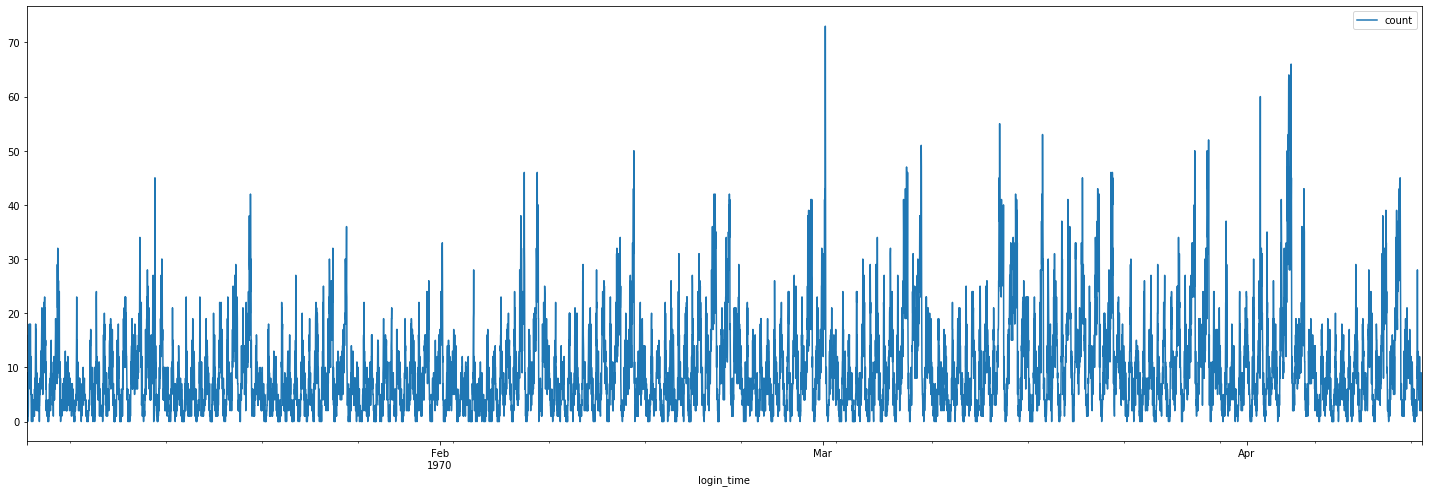

In [8]:
#visualize and describe the resulting time series of login counts

logins_agg.plot(x='login_time', y='count', figsize=(25,8))
plt.show()

<IPython.core.display.Javascript object>

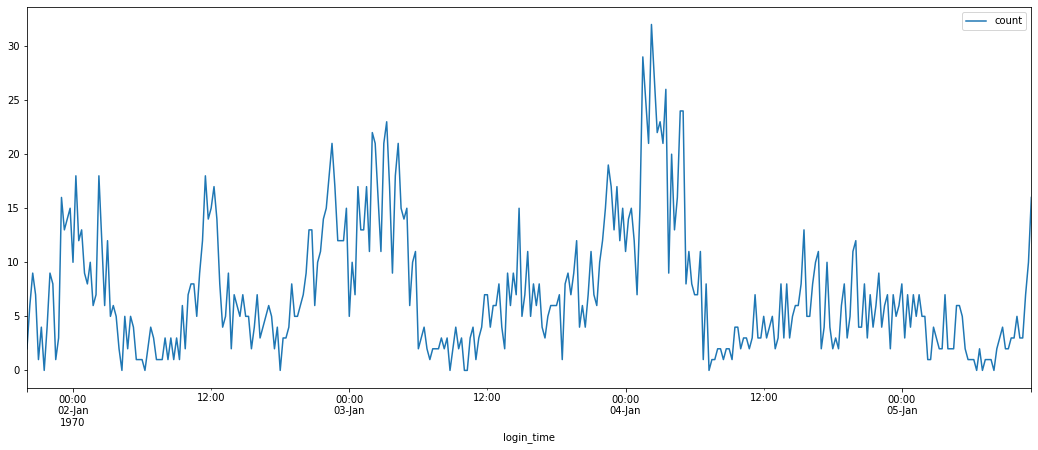

<IPython.core.display.Javascript object>

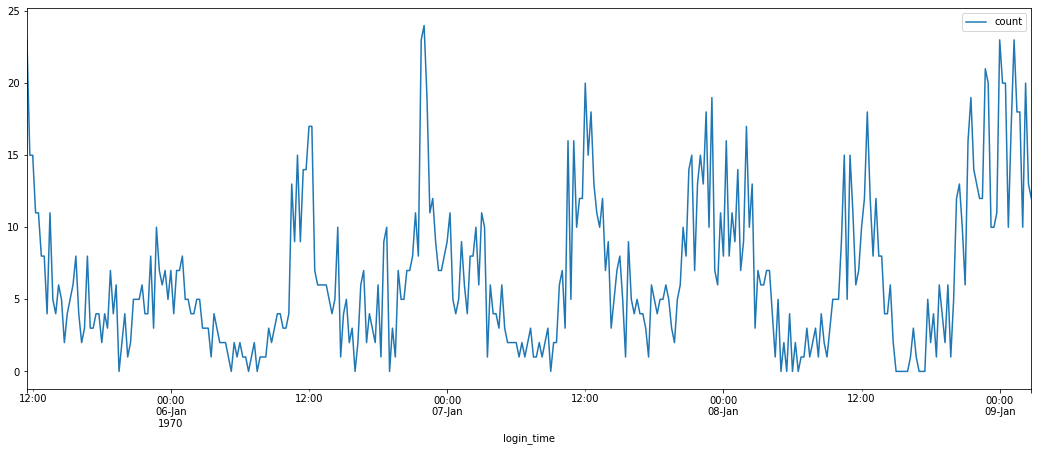

<IPython.core.display.Javascript object>

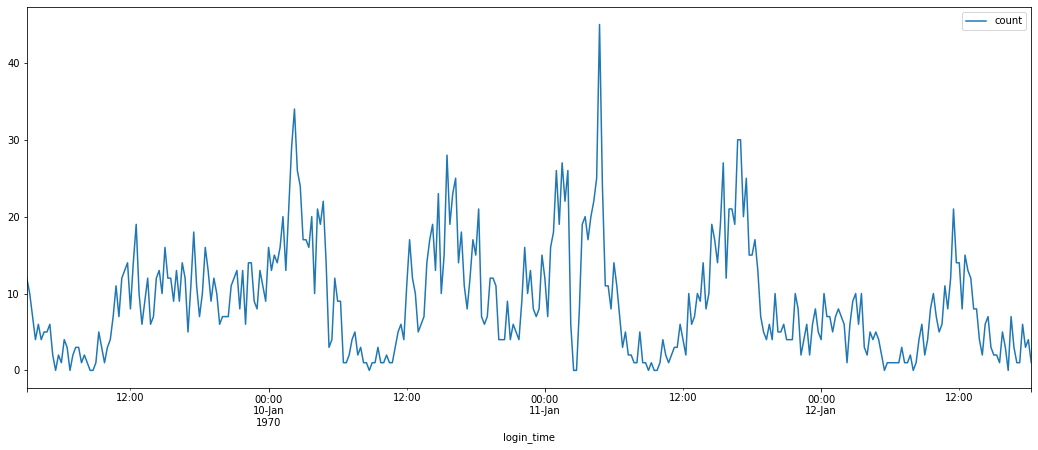

<IPython.core.display.Javascript object>

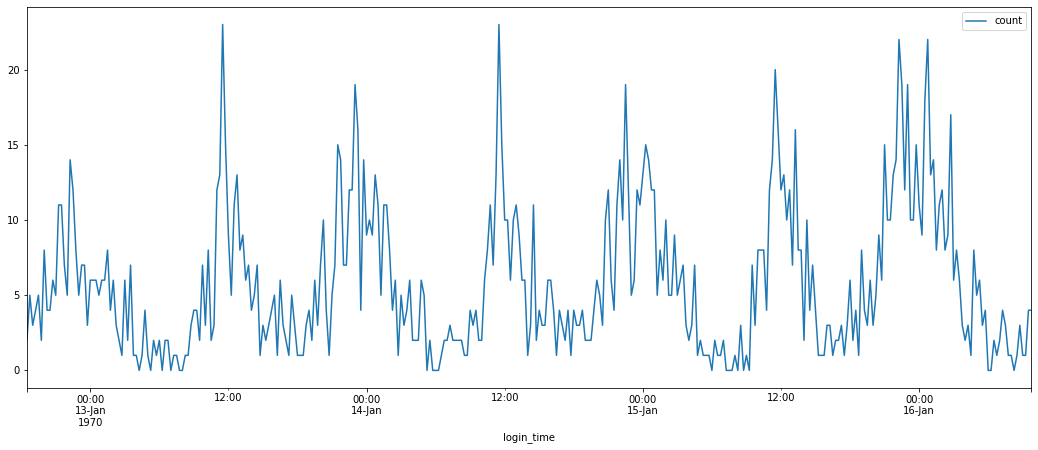

<IPython.core.display.Javascript object>

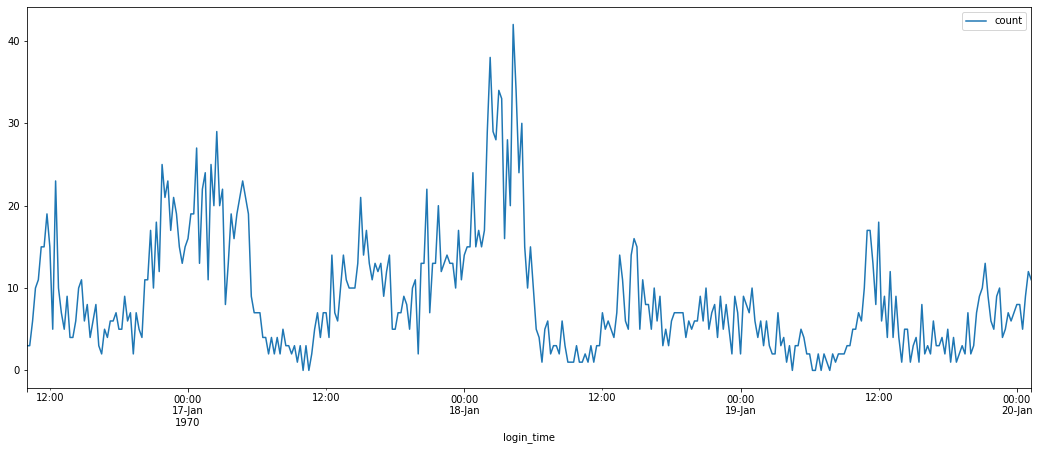

<IPython.core.display.Javascript object>

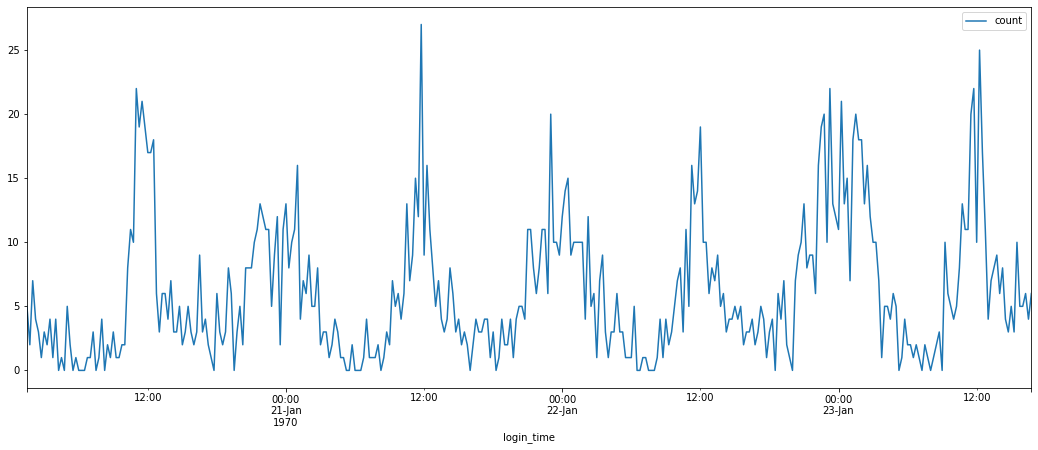

<IPython.core.display.Javascript object>

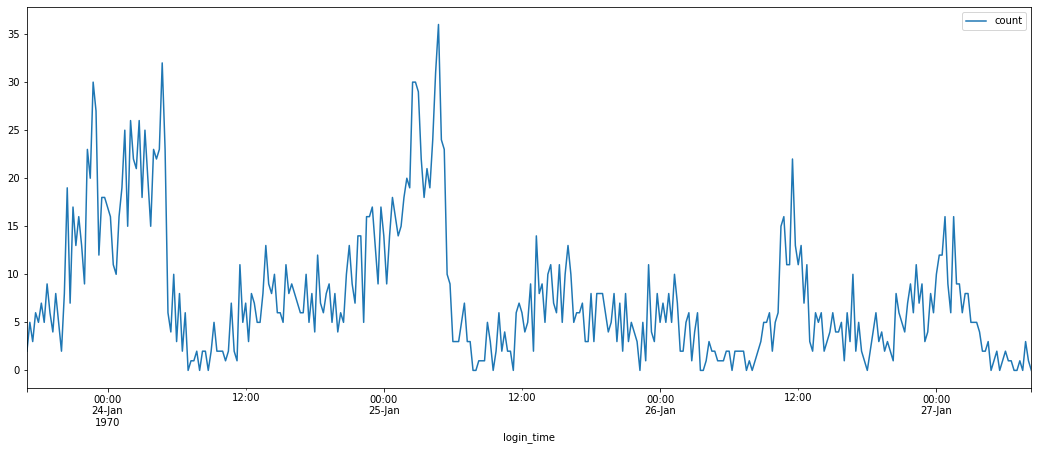

<IPython.core.display.Javascript object>

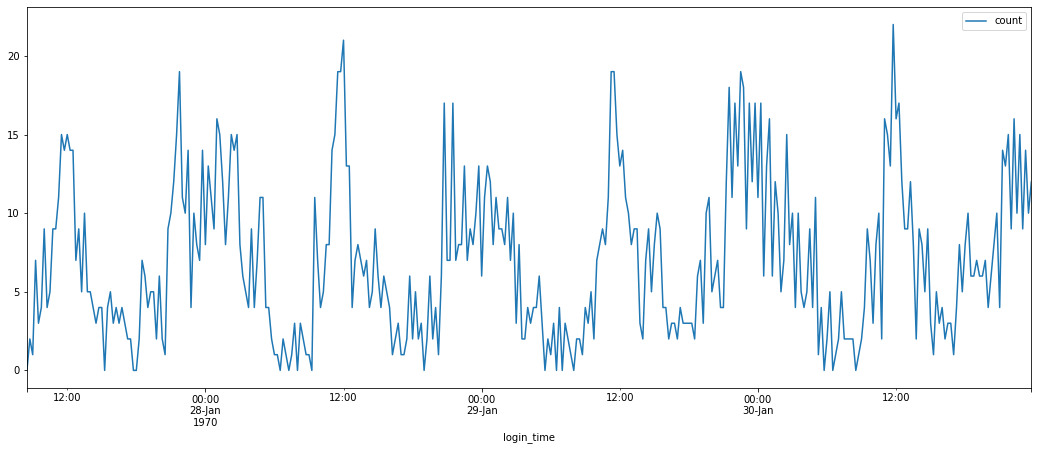

<IPython.core.display.Javascript object>

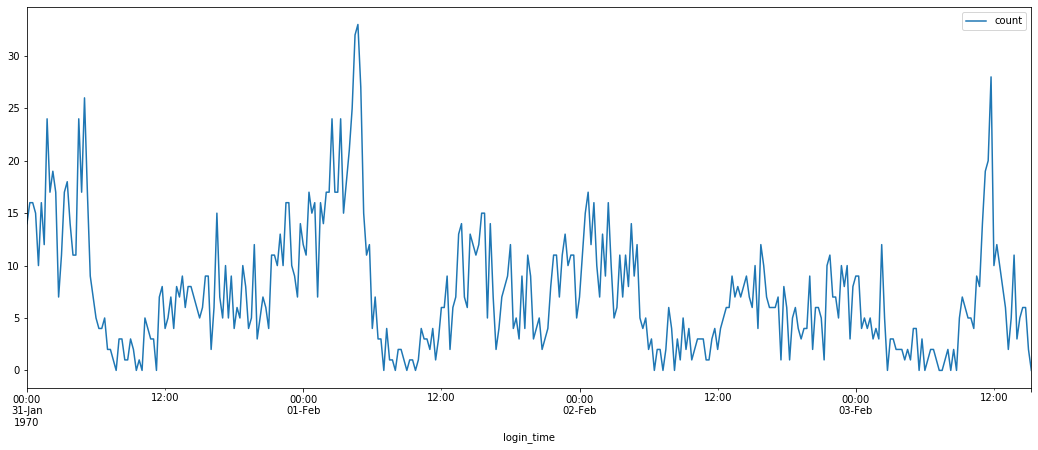

<IPython.core.display.Javascript object>

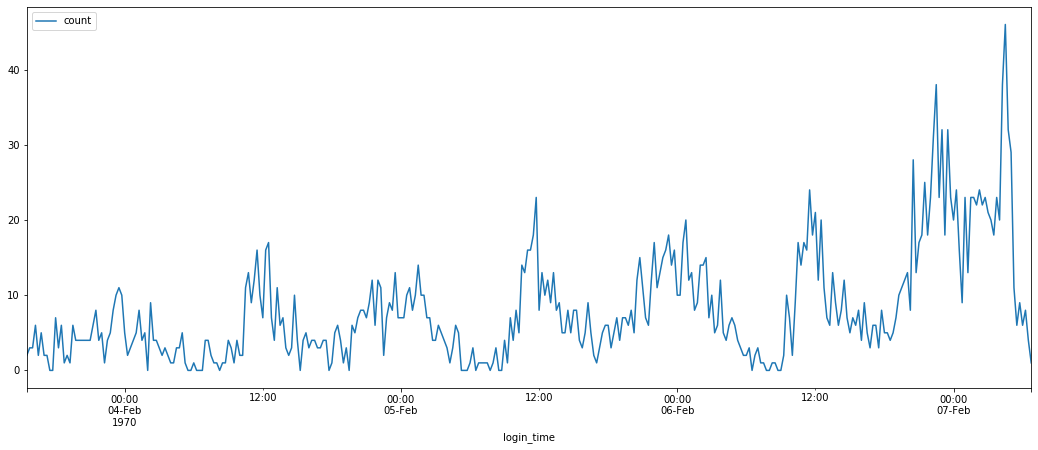

In [14]:
#To have a clear view of the time series patters it is important to look at a snap shot of smaller time series and maginify. 
# maginify so taht we can view important features of the demand on a daily cycles. 
snap_shot = 350
for i in range(10):
    logins_agg.iloc[i*snap_shot:(i+1)*snap_shot, :].plot(x='login_time', y='count', figsize=(18,7))
    plt.show()

`Observation:` The time series plots above shows that there is a general daily pattern, where we observed demand picking at noon (00:00) and midnight (12:00). 

## Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

To help decide the Ultimate manageres of city opaerations for the two cities if their propsoed expermental policy change is sucessful, I will need to run an `A/B hypotesis testing` to determine whether the proportion of driver partners serviing both cities before and after the policy change is the same (null hypothesis) or diffrent (alternative hypothesis). 

#### Implementation 
To sucessfuly implement the the hypothesis testing, we will need to obtain toll-bridge data, specifically data on date and time crossed and direction of the toll-bridge cross (Gotham - Metropolis and Metropolis - Gotham directions). 

After data obtained, I will run a two-tailed t-statistis to compare the statistical significance of the proportion of driver partners in the two cities, before the policy change was implemented and after the policy change was implemented. I will use 95% confidence level (`alpha` =0.05, 5% level of signficiance). If i have p-value less than 0.05, then I will reject the null hypothesis that claims two proportion are the same, and accept with 95% confidence, the claim that the diffrence in the proportion of direver partners before and after the policy change is due to the policy proposed by the Ultimate managers of city operations for the two cities, not random error. 

## Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. We consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.


In [34]:
import json
#First read the given dataset 
with open('ultimate_data_challenge.json', 'r') as file:
    data = json.load(file)
reten_data = pd.DataFrame(data)
reten_data

<IPython.core.display.Javascript object>

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [20]:
reten_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### Cleaning Dataset

Retention is defined if a user retianed were 'active' (that is took a trip) in the preceding 30 days. First, we will need to create our target variable - `user_is_retained`, with value `1` if the a user took a trip in the preceding 30 days, and `0` otherwise.  

From the data its not obvious to determine the baseline date used to determine the preceding 30 days, for this challenge I will use the latest date from `last_trip_date` - that is `max()` of `last_trip_date`. 



In [22]:
recent_date=reten_data.last_trip_date.max()
print('the most recent date is : {}'.format(recent_date))

the most recent date is : 2014-07-01


In [35]:
reten_data['user_is_retained']=(reten_data.last_trip_date < '2014-06-01').astype(int)
reten_data

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,user_is_retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,1
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,0
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,1
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,1
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,1


In [29]:
# what fraction of the observed users were retained 
retained = reten_data.user_is_retained.mean()*100
print('Percentage of users retained is: {}'.format(retained))

Percentage of users retained is: 62.392


In [30]:
reten_data['user_is_retained'].value_counts(normalize=True) * 100

1    62.392
0    37.608
Name: user_is_retained, dtype: float64

<IPython.core.display.Javascript object>

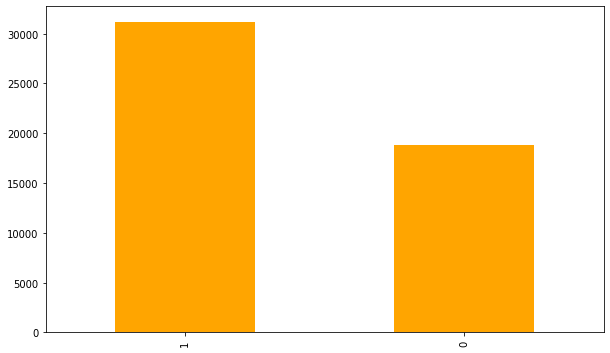

In [31]:
#visualize again to check if everyting looks good. 
plt.figure(figsize = (10, 6))
reten_data['user_is_retained'].value_counts().plot(kind='bar', color='orange')

In [27]:
#create array for target variable 
y = reten_data['user_is_retained']
y

0        0
1        1
2        1
3        0
4        1
        ..
49995    0
49996    1
49997    1
49998    1
49999    1
Name: user_is_retained, Length: 50000, dtype: int32

In [36]:
# Features 
# Create dummy variables for city - this allows us to check if individual city features play role in explaining our tearget - retaintion
city_dummy =pd.get_dummies(reten_data.city)
city_dummy



<IPython.core.display.Javascript object>

,Astapor,King's Landing,Winterfell
0,0,1,0
1,1,0,0
2,1,0,0
3,0,1,0
4,0,0,1
...,...,...,...
49995,0,1,0
49996,1,0,0
49997,0,0,1
49998,1,0,0


In [39]:
#manage null values 
#avg_rating_of_driver has 8122 null values (16%). We will fill the null values with the mean value. This will not affect rating distribution. 
reten_data.avg_rating_of_driver=reten_data.avg_rating_of_driver.fillna(reten_data.avg_rating_of_driver.mean())

#avg_rating_by_driver has 201 null values (0.4%). We will fill the null values wiht the mean value. 
reten_data.avg_rating_by_driver=reten_data.avg_rating_by_driver.fillna(reten_data.avg_rating_by_driver.mean())

In [40]:
reten_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
user_is_retained          50000 non-null int32
dtypes: bool(1), float64(6), int32(1), int64(1), object(4)
memory usage: 4.4+ MB


In [38]:
reten_data['phone'].value_counts(normalize=True) * 100

iPhone     69.716152
Android    30.283848
Name: phone, dtype: float64

In [41]:

#phone has 396 data points with null values. 70% users use iphone. We can create iphone dummy and this will not affect our data significantly.
reten_data.phone=pd.get_dummies(reten_data.phone, drop_first=True)

<IPython.core.display.Javascript object>

In [48]:
#create num_active_days
reten_data['num_active_days'] = pd.to_datetime(reten_data.last_trip_date).subtract(pd.to_datetime(reten_data.signup_date)) / np.timedelta64(1,'D')
reten_data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,user_is_retained,num_active_days
0,King's Landing,4,2014-01-25,4.700000,1.10,2014-06-17,1,15.4,1,46.2,3.67,5.0,0,143.0
1,Astapor,0,2014-01-29,5.000000,1.00,2014-05-05,0,0.0,0,50.0,8.26,5.0,1,96.0
2,Astapor,3,2014-01-06,4.300000,1.00,2014-01-07,1,0.0,0,100.0,0.77,5.0,1,1.0
3,King's Landing,9,2014-01-10,4.600000,1.14,2014-06-29,1,20.0,1,80.0,2.36,4.9,0,170.0
4,Winterfell,14,2014-01-27,4.400000,1.19,2014-03-15,0,11.8,0,82.4,3.13,4.9,1,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.000000,1.00,2014-06-05,1,0.0,0,100.0,5.63,4.2,0,131.0
49996,Astapor,1,2014-01-24,4.601559,1.00,2014-01-25,1,0.0,0,0.0,0.00,4.0,1,1.0
49997,Winterfell,0,2014-01-31,5.000000,1.00,2014-05-22,0,0.0,1,100.0,3.86,5.0,1,111.0
49998,Astapor,2,2014-01-14,3.000000,1.00,2014-01-15,1,0.0,0,100.0,4.58,3.5,1,1.0


In [42]:
# transform ultimate_black_user to binary values 
reten_data['ultimate_black_user'] = (reten_data.ultimate_black_user).astype(int)
reten_data

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,user_is_retained
0,King's Landing,4,2014-01-25,4.700000,1.10,2014-06-17,1,15.4,1,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.000000,1.00,2014-05-05,0,0.0,0,50.0,8.26,5.0,1
2,Astapor,3,2014-01-06,4.300000,1.00,2014-01-07,1,0.0,0,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.600000,1.14,2014-06-29,1,20.0,1,80.0,2.36,4.9,0
4,Winterfell,14,2014-01-27,4.400000,1.19,2014-03-15,0,11.8,0,82.4,3.13,4.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.000000,1.00,2014-06-05,1,0.0,0,100.0,5.63,4.2,0
49996,Astapor,1,2014-01-24,4.601559,1.00,2014-01-25,1,0.0,0,0.0,0.00,4.0,1
49997,Winterfell,0,2014-01-31,5.000000,1.00,2014-05-22,0,0.0,1,100.0,3.86,5.0,1
49998,Astapor,2,2014-01-14,3.000000,1.00,2014-01-15,1,0.0,0,100.0,4.58,3.5,1


In [49]:
#remove uncessary features 
reten_data=reten_data.drop(columns=['city', 'last_trip_date', 'signup_date'])
reten_data

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,user_is_retained,num_active_days
0,4,4.700000,1.10,1,15.4,1,46.2,3.67,5.0,0,143.0
1,0,5.000000,1.00,0,0.0,0,50.0,8.26,5.0,1,96.0
2,3,4.300000,1.00,1,0.0,0,100.0,0.77,5.0,1,1.0
3,9,4.600000,1.14,1,20.0,1,80.0,2.36,4.9,0,170.0
4,14,4.400000,1.19,0,11.8,0,82.4,3.13,4.9,1,47.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.000000,1.00,1,0.0,0,100.0,5.63,4.2,0,131.0
49996,1,4.601559,1.00,1,0.0,0,0.0,0.00,4.0,1,1.0
49997,0,5.000000,1.00,0,0.0,1,100.0,3.86,5.0,1,111.0
49998,2,3.000000,1.00,1,0.0,0,100.0,4.58,3.5,1,1.0


In [50]:
#concatenate all features 
reten_data=pd.concat([reten_data, city_dummy], axis=1)
reten_data

<IPython.core.display.Javascript object>

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,user_is_retained,num_active_days,Astapor,King's Landing,Winterfell
0,4,4.700000,1.10,1,15.4,1,46.2,3.67,5.0,0,143.0,0,1,0
1,0,5.000000,1.00,0,0.0,0,50.0,8.26,5.0,1,96.0,1,0,0
2,3,4.300000,1.00,1,0.0,0,100.0,0.77,5.0,1,1.0,1,0,0
3,9,4.600000,1.14,1,20.0,1,80.0,2.36,4.9,0,170.0,0,1,0
4,14,4.400000,1.19,0,11.8,0,82.4,3.13,4.9,1,47.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.000000,1.00,1,0.0,0,100.0,5.63,4.2,0,131.0,0,1,0
49996,1,4.601559,1.00,1,0.0,0,0.0,0.00,4.0,1,1.0,1,0,0
49997,0,5.000000,1.00,0,0.0,1,100.0,3.86,5.0,1,111.0,0,0,1
49998,2,3.000000,1.00,1,0.0,0,100.0,4.58,3.5,1,1.0,1,0,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[Text(0.5, 1, 'Correlations: User retaintion Correlation')]

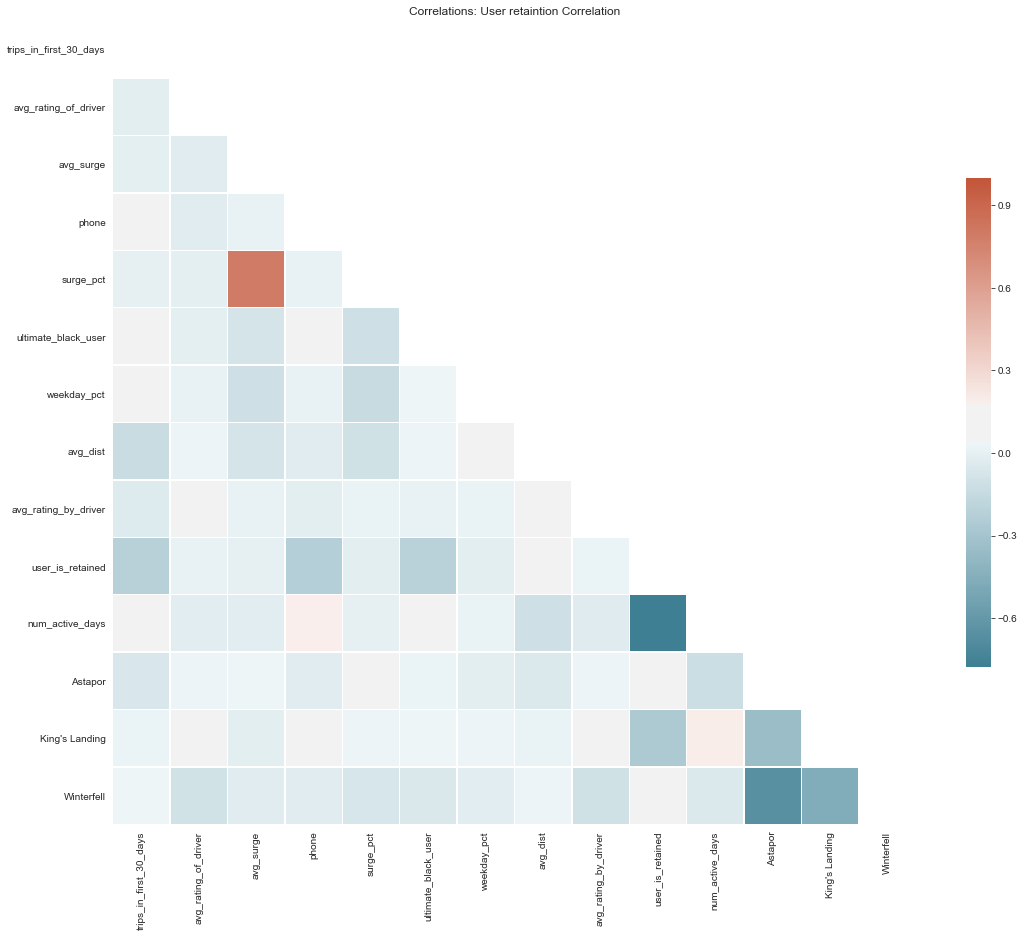

In [78]:

# Compute correlations
corr = reten_data.corr()

# Exclude duplicate correlations by masking uper right values
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set background color / chart style
sns.set_style(style = 'white')

# Set up  matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Add diverging colormap
#cmap =sns.diverging_palette(150, 275, s=80, l=55, n=12)
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

# Draw correlation plot
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
ax.set (title='Correlations: User retaintion Correlation')

### Build a predictive model 

Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance. 

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [53]:
#preprocessing 
x = reten_data.drop(columns=['user_is_retained']) #drop target from features 
y = reten_data['user_is_retained'] # target is 'user_is_retained'

In [55]:
#feature scaling
sc=StandardScaler()
x=sc.fit_transform(x)
x

array([[ 4.53983824e-01,  1.74240305e-01,  1.13505916e-01, ...,
        -7.02889512e-01,  1.98389369e+00, -9.35514574e-01],
       [-6.00688784e-01,  7.05241067e-01, -3.36268282e-01, ...,
         1.42269871e+00, -5.04059269e-01, -9.35514574e-01],
       [ 1.90315672e-01, -5.33760712e-01, -3.36268282e-01, ...,
         1.42269871e+00, -5.04059269e-01, -9.35514574e-01],
       ...,
       [-6.00688784e-01,  7.05241067e-01, -3.36268282e-01, ...,
        -7.02889512e-01, -5.04059269e-01,  1.06893043e+00],
       [-7.33524799e-02, -2.83476401e+00, -3.36268282e-01, ...,
         1.42269871e+00, -5.04059269e-01, -9.35514574e-01],
       [-6.00688784e-01, -2.76400669e-13, -3.36268282e-01, ...,
         1.42269871e+00, -5.04059269e-01, -9.35514574e-01]])

In [56]:
#split into training/testing sets with 20% split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [73]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    #Names of models
    model_name_list = ['Logistic Regression', 'Random Forest', 'Extra Trees',
                       'Gradient Boosted']
    model = np.arange(1, 5)
    train_accuracy = np.empty(len(model))
    test_accuracy = np.empty(len(model))
    # Instantiate the models
    model1 = LogisticRegression(solver='lbfgs')
    model2 = RandomForestClassifier(n_estimators=100)
    model3 = ExtraTreesClassifier(n_estimators=100)
    model4 = GradientBoostingClassifier(n_estimators=100)
    results =pd.DataFrame(columns=['train_accuracy', 'test_accuracy', 'AUC'])    
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4]):
        model.fit(X_train, y_train)
        
        train_accuracy=model.score(X_train, y_train)
        test_accuracy=model.score(X_test, y_test)
        y_pred = model.predict(x_test)
        auc = roc_auc_score(y_test, y_pred)
        
        model_name=model_name_list[i]
        results.loc[model_name, :] =[train_accuracy, test_accuracy, auc]
    return results

In [74]:
results = evaluate(x_train, x_test, y_train, y_test)
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,train_accuracy,test_accuracy,AUC
Logistic Regression,0.9593,0.9605,0.958911
Random Forest,1,0.9586,0.956917
Extra Trees,1,0.9547,0.952796
Gradient Boosted,0.961975,0.9601,0.959263


I have used Logistic regression model and esemble methods such as RandomForestClassifier, ExtraTreesClassifier, and GradientBoosting Classifier. Logistic Regression and Gradient Bosting Classifiers predicted with training and testing accuracy of 96%, and area under the curve score of 96%. With 100% training accuracy score, Random Forest and Extra Trees classifiers may have been impacted by overfitting. 

In [77]:
model_weights = pd.DataFrame({'features': reten_data.drop(columns=['user_is_retained']).columns.tolist(), 'weights': model.coef_.tolist()[0]})
model_weights.sort_values(by='weights')

<IPython.core.display.Javascript object>

,features,weights
9,num_active_days,-12.139570
11,King's Landing,-0.425197
5,ultimate_black_user,-0.402125
3,phone,-0.363711
0,trips_in_first_30_days,-0.222970
2,avg_surge,-0.085707
7,avg_dist,0.008367
1,avg_rating_of_driver,0.025063
8,avg_rating_by_driver,0.071505
4,surge_pct,0.084141


### Conclusion 

The most important variable in predicting retention is the number of active days the user has had an account. Users who are actively using Ultimate are more likely to continue using Ultimate services. Managers will need to redirect their investment in marketing strategies to incentivise users. 